<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 3 (Assignment) -- The Vanishing Gradient Problem</h2>

<b>Authors:</b> Brandstetter, Schäfl<br>
<b>Date:</b> 23-03-2020

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

# Exercise 0

- Import the same modules as discussed in the lecture notebook.
- Check if your model versions are correct.

In [3]:
# your imports go here
import u3_utils as u3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial
from pathlib import Path
from PIL import Image, ImageOps
from scipy import signal
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# model version checks
u3.check_module_versions()

Installed Python version: 3.7 (✓)
Installed numpy version: 1.18.1 (✓)
Installed pandas version: 0.25.1 (✗)
Installed PyTorch version: 1.4.0 (✓)
Installed scikit-learn version: 0.22.1 (✓)
Installed scipy version: 1.4.1 (✓)
Installed matplotlib version: 3.1.3 (✓)
Installed seaborn version: 0.10.0 (✓)
Installed PIL version: 7.0.0 (✓)


# Exercise 1

- Load the Fashion-MNIST dataset.
- Display the first 5 elements of the dataset.
- Create a training and a test dataset (ratio $7:3$)

In [5]:
# your code for loading and displaying the Fashion MNIST dataset goes here
fashion_mnist_data = u3.load_fashion_mnist()
fashion_mnist_data[:5]

,PX_0,PX_1,PX_2,PX_3,PX_4,PX_5,PX_6,PX_7,PX_8,PX_9,...,PX_775,PX_776,PX_777,PX_778,PX_779,PX_780,PX_781,PX_782,PX_783,item_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
np.random.seed(42)
# your code goes here
np.random.seed(42)
fashion_mnist_train, fashion_mnist_test = u3.split_data(fashion_mnist_data, test_size=0.3)

# Interlude (nothing to do here)

We set here the input dimension, the output dimension and the device used for calculation (GPU if available).

In [7]:
input_dim = 784
output_dim = 10
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')

We create a dataloader for the training and for the test data set:

In [8]:
image_width = int(np.sqrt(len(fashion_mnist_train.iloc[0])))

# Create instance of Dataloader (training set).
fashion_mnist_loader_train = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_train.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_train), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_train[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=True, drop_last=False)

# Create instance of Dataloader (test set).
fashion_mnist_loader_test = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_test.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_test), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_test[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=False, drop_last=False)

# Exercise 2

- Create a logistic regression module.
- Use the <code>nn.Sequential</code> container.
- Run your neural network on the complete Fashion-MNIST dataset for $5$ epochs.
- Report your results on the training set after each epoch.
- Run you final model on the test set, also report you results.

In [9]:
class logistic_regression(nn.Module):
    def __init__(self, D_in, D_out):
        super(logistic_regression, self).__init__()
        
        
        # your sequential code goes here
        self.model = nn.Sequential(
            nn.Linear(D_in, D_out, bias=True)
        )
    def forward(self, x):
        # your forward pass goes here
        return self.model(x)

In [10]:
# initialize your model
logistic_regression_model = logistic_regression(input_dim,output_dim)

In [11]:
np.random.seed(42)
torch.manual_seed(42)

optimizer = optim.SGD(logistic_regression_model.parameters(), lr=1e-4, momentum=0.5)

# your code goes here
num_epochs = 5
for epoch in range(num_epochs):
    
    # Train LR for one epoch.
    _ = u3.train_network(model=logistic_regression_model, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current LR model on training data set.
    performance = u3.test_network(
        model=logistic_regression_model, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u3.test_network(
    model=logistic_regression_model, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 1 / Loss: 0.0758 / Accuracy: 0.7823
Epoch: 2 / Loss: 0.0609 / Accuracy: 0.7939
Epoch: 3 / Loss: 0.0669 / Accuracy: 0.7963
Epoch: 4 / Loss: 0.0461 / Accuracy: 0.8260
Epoch: 5 / Loss: 0.0659 / Accuracy: 0.7831

Final loss: 0.0713 / Final accuracy: 0.7793


# Exercise 3

- Implement the following neural network architecture: <br>
1) Input layer $784 \rightarrow 512$  ($\tanh$ activation function) <br>
2) $5$ hidden layers $512 \rightarrow 512$ ($\tanh$ activation function) <br>
3) Output layer $512 \rightarrow 10$ <br>

- Print out your network architecture.
- Run your neural network on the complete Fashion-MNIST dataset for $5$ epochs.
- Report your results on the training set after each epoch.
- Run you final model on the test set, also report you results.
- Plot the gradients in the hidden layers (and the input layer).

In [12]:
class neural_network_tanh(nn.Module):
    def __init__(self, D_in, D_out):
        super(neural_network_tanh, self).__init__()
        
        # your sequential code goes here
        self.model = nn.Sequential(
            nn.Linear(D_in, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 10, bias=True)
        )

    def forward(self, x):
        # your forward pass goes here
        return self.model(x)

In [13]:
# initialize your model
neural_network_model3 = neural_network_tanh(input_dim,output_dim)

In [14]:
# print your network architecture
neural_network_model3

neural_network_tanh(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Tanh()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): Tanh()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Tanh()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [15]:
np.random.seed(42)
torch.manual_seed(42)

optimizer = optim.SGD(neural_network_model3.parameters(), lr=1e-3, momentum=0.5)

# your code goes here
num_epochs = 5
for epoch in range(num_epochs):
    
    # Train LR for one epoch.
    gradients = u3.train_network(model=neural_network_model3, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current LR model on training data set.
    performance = u3.test_network(
        model=neural_network_model3, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u3.test_network(
    model=neural_network_model3, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 1 / Loss: 0.0166 / Accuracy: 0.4877
Epoch: 2 / Loss: 0.0129 / Accuracy: 0.4556
Epoch: 3 / Loss: 0.0106 / Accuracy: 0.5528
Epoch: 4 / Loss: 0.0090 / Accuracy: 0.6019
Epoch: 5 / Loss: 0.0077 / Accuracy: 0.6482

Final loss: 0.0078 / Final accuracy: 0.6442


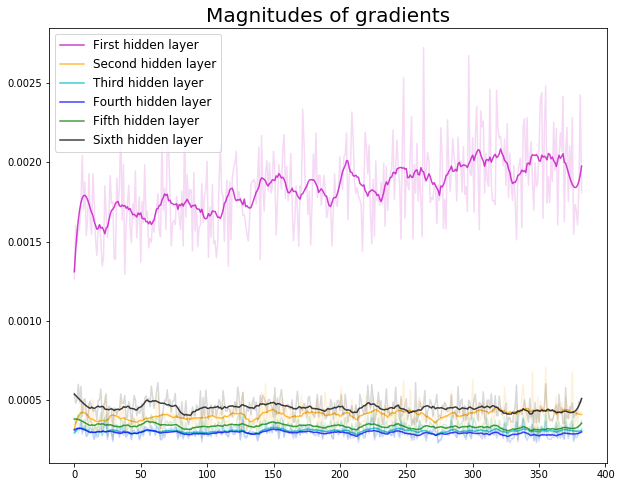

In [16]:
# plot gradients
u3.plt_gradients(gradients)

# Exercise 4

- Plot the $\tanh$ activation function and its derivative: <br>
1) Write a function which returns the tanh for arbitrary input values. <br>
2) Write a function which returns the derivative of the tanh for arbitrary input values. <br>
3) Plot them together.

In [17]:
def tanh(x):
    # your code goes here
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))


def dtanh(x):
    # your code goes here
    return 1-tanh(x)**2

def plt_activation_tanh():
    X = np.linspace(-5, 5, 100)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    plt.plot(X, tanh(X), color="#307EC7", linewidth=3, label='tanh')
    plt.plot(X, dtanh(X), color="#accbe8", linewidth=3, label='derivative of tanh')
    plt.locator_params(axis='y', nbins=6)
    plt.title('Tanh function', fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()
    # your code goes here

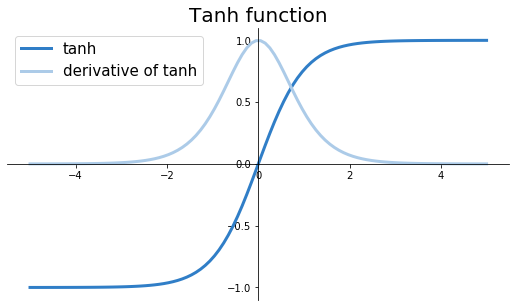

In [18]:
# call the plotting function
plt_activation_tanh()

# Exercise 5

- Plot the $\text{selu}$ activation function and its derivative: <br>
1) Write a function which returns $\text{selu}(x)$ for arbitrary input values $x$. <br>
2) Write a function which returns the derivative of $\text{selu}(x)$ for arbitrary input values $x$. <br>
3) Plot them together. <br>

- The $\text{selu}$ function is defined as following:
\begin{align*}
selu(x)=\lambda\begin{cases}
    x & \text{if } x\geq 0\\
    \alpha\exp(x)-\alpha              & \text{if } x<0
\end{cases} 
\end{align*}
where $\alpha = 1.6732...$ and $\lambda = 1.0507...$ 

In [24]:
lambda_ = 1.0507
alpha_ = 1.6732

def selu(x):
    # your code goes here
    sel = np.where(x<=0.0,lambda_*(alpha_*np.exp(x)-alpha_),lambda_*x)
    return sel

    

def dselu(x):
    # your code goes here
    sel = np.where(x<=0.0,lambda_*alpha_*np.exp(x),lambda_)
    return sel


def plt_activation_selu():
    X = np.linspace(-2.5, 2.5, 500)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    plt.ylim(-2., 2.)
    # your code goes here
    plt.plot(X, selu(X), color="#e22182", linewidth=3, label='selu')
    plt.plot(X, dselu(X), color="#accbe8", linewidth=3, label='derivate of selu')

    plt.locator_params(axis='y', nbins=4)
    plt.title('SeLU function',fontsize=20)
    plt.legend(prop={'size': 15})
    plt.show()

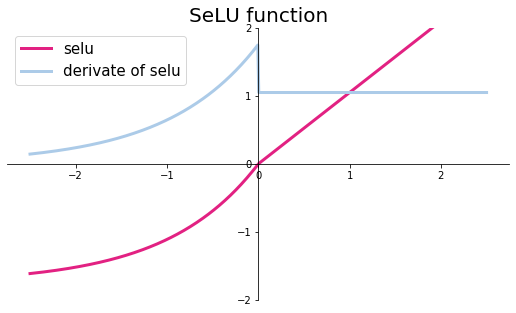

In [25]:
# call the plotting function
plt_activation_selu()

# Exercise 6

- Repeat the steps of Exercise 3, but use a $\text{selu}$ activation function instead of the $\tanh$ activation function.<br> (Hint: use the nn.SELU() function)

In [26]:
class neural_network_selu(nn.Module):
    def __init__(self, D_in, D_out):
        super(neural_network_selu, self).__init__()
        
         # your sequential code goes here
        self.model= nn.Sequential(nn.Linear(D_in, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 512, bias=True),
            nn.SELU(),
            nn.Linear(512, 10, bias=True)
                                     )

    def forward(self, x):
        return self.model(x)

In [27]:
# initialize your model
neural_network = neural_network_selu(input_dim, output_dim).to(target_device)

In [28]:
# print your architectur
neural_network 

neural_network_selu(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SELU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SELU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): SELU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): SELU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [29]:
np.random.seed(42)
torch.manual_seed(42)

optimizer = optim.SGD(neural_network.parameters(), lr=1e-3, momentum=0.5)

num_epochs = 3
for epoch in range(num_epochs):
    
    # Train LR for one epoch.
    gradients = u3.train_network(model=neural_network, data_loader=fashion_mnist_loader_train,
                     device=target_device, optimizer=optimizer)
    
    # Evaluate current LR model on training data set.
    performance = u3.test_network(
        model=neural_network, data_loader=fashion_mnist_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')
    
# Evaluate final model on test data set.
performance = u3.test_network(
    model=neural_network, data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 1 / Loss: 0.0034 / Accuracy: 0.8481
Epoch: 2 / Loss: 0.0029 / Accuracy: 0.8689
Epoch: 3 / Loss: 0.0026 / Accuracy: 0.8837

Final loss: 0.0029 / Final accuracy: 0.8666


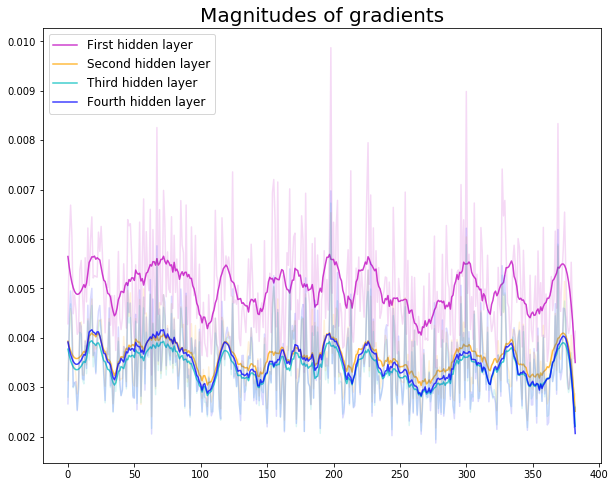

In [30]:
# plot gradients
u3.plt_gradients(gradients)